# SIS 6223 – Natural Language Processing Assignment I

This notebook explores and compares different Information Retrieval (IR) techniques for searching a corpus of documents (specifically, UN Security Council resolutions). The process covers:

1. **Data Loading & Preprocessing** :
- Downloading and extracting the document corpus.
- Importing necessary libraries (NLTK, etc.) and downloading linguistic resources.
- Defining functions to clean and preprocess the text data (removing templates, tokenization, lemmatization, stopword removal).
- Applying preprocessing to the entire document corpus.

2. **Traditional IR Models**:
- BM25: Implementation and search using the BM25 algorithm.
- TF-IDF: Implementation using scikit-learn's TfidfVectorizer and search based on cosine similarity.
- Whoosh: Implementation using the Whoosh library, including index creation and keyword-based search.

3. **Advanced Neural Information Retrieval (IR)**:
- Implementing a two-stage "retrieve and re-rank" pipeline.
- Retrieval Stage (Bi-Encoder): Using a Sentence Transformer model (all-mpnet-base-v2) to generate dense vector embeddings for the corpus and indexing them with FAISS for fast similarity search.
- Re-ranking Stage (Cross-Encoder): Using a Cross-Encoder model (cross-encoder/ms-marco-MiniLM-L-6-v2) to re-rank the initial set of retrieved documents for improved accuracy.

4. **Evaluation**:
- Defining evaluation queries (both terminological and conceptual).
- Creating ground truth relevance judgments for the evaluation queries.
- Implementing standard IR evaluation metrics (Precision@k, Mean Average Precision, nDCG@k).
- Executing search experiments across all implemented models (BM25, TF-IDF, Whoosh, Bi-encoder, Cross-encoder).
- Computing and comparing the evaluation metrics for all models, both overall and specifically for terminological and conceptual queries.
- Visualizing the performance metrics using bar charts.
- Identifying queries where the Cross-encoder provided significant re-ranking improvement.

This notebook provides a practical implementation and comparison of various IR techniques, demonstrating the shift from traditional keyword-based methods to more advanced neural approaches.

# 1. Data Exploration & Preprocessing


In [ ]:
!pip install nltk rank_bm25

Import necessary libraries and downloads data required for Natural Language Processing (NLP) tasks using the NLTK library

In [ ]:
import os, re, glob, json, nltk, random
import numpy as np
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from rank_bm25 import BM25Okapi

nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

True

Download zip file containing data, extracts its contents, and then removes the downloaded zip file

In [ ]:
!wget -q -O CR.zip https://zenodo.org/records/11212056/files/CR-UNSC_2024-05-19_EN_TXT_BEST.zip?download=1
!unzip -q CR.zip -d dataset/ && rm CR.zip
TXT_FILES = glob.glob("dataset/*.txt")

replace dataset/S_RES_0001_1946_EN_GOLD.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace dataset/S_RES_0002_1946_EN_GOLD.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace dataset/S_RES_0002_1946_EN_GOLD.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


This cell prepares a set of English stopwords (with some exceptions) and a lemmatizer object for cleaning and normalizing the text data.

In [ ]:
STOP = set(stopwords.words("english")) - {"not", "shall", "no", "without"}
LEMMA = WordNetLemmatizer()

This cell provides the core logic for cleaning and preparing the raw text documents for use with the search models by removing unwanted elements and normalizing the text.

In [ ]:
def remove_uscouncil_templates(text: str) -> str:
    # General  DD MMM YYYY
    text = re.sub(r"S/RES/\d+.*?Distr\.: General.*?\n", "", text, flags=re.S | re.I)
    # page footers
    text = re.sub(r"Page \d+ of \d+.*?\n", "", text, flags=re.I)
    # copyright line
    text = re.sub(r"©.*?20\d{2}.*?\n", "", text, flags=re.I)
    return text


def preprocess(text: str) -> list[str]:
    """split → tokenise → clean → lemmatise."""
    text = remove_uscouncil_templates(text)
    sents = sent_tokenize(text)
    tokens = []
    for sent in sents:
        sent = re.sub(r"\s+", " ", sent.strip().lower())
        toks = word_tokenize(sent)
        toks = [LEMMA.lemmatize(t) for t in toks
                if t.isalpha() and t not in STOP]
        tokens.extend(toks)
    return tokens

 This cell reads all the text documents, preprocesses them using the defined function, stores the processed text and original filenames, and then uses the processed text to build a searchable index using the BM25 algorithm.

In [ ]:
processed_docs, doc_ids = [], []
for fp in TXT_FILES:
    with open(fp, encoding="utf-8") as f:
        processed_docs.append(preprocess(f.read()))
    doc_ids.append(os.path.basename(fp))

bm25 = BM25Okapi(processed_docs)
print("🔍 BM25 index built")

🔍 BM25 index built


This code cell defines example search queries just for testing, implements a search function using the BM25 index, and then runs those queries, printing the top results.

In [ ]:
QUERIES = ["peacekeeping force", "sanctions against iran", "ceasefire agreement"]

def search(query: str, k: int = 3):
    qtok = preprocess(query)
    scores = bm25.get_scores(qtok)
    top = sorted(enumerate(scores), key=lambda x: x[1], reverse=True)[:k]
    return [(doc_ids[i], s) for i, s in top]

print("\n" + "="*60)
for q in QUERIES:
    print(f"\nQuery: {q!r}")
    for rank, (did, sc) in enumerate(search(q), 1):
        print(f"{rank}. {did}  (score {sc:.4f})")
print("="*60)



Query: 'peacekeeping force'
1. S_RES_1327_2000_EN.txt  (score 6.6788)
2. S_RES_1311_2000_EN.txt  (score 6.6335)
3. S_RES_1096_1997_EN.txt  (score 6.6281)

Query: 'sanctions against iran'
1. S_RES_2231_2015_EN.txt  (score 13.0989)
2. S_RES_1929_2010_EN.txt  (score 11.1211)
3. S_RES_1803_2008_EN.txt  (score 11.0169)

Query: 'ceasefire agreement'
1. S_RES_2694_2023_EN.txt  (score 5.2597)
2. S_RES_1279_1999_EN.txt  (score 5.1727)
3. S_RES_1291_2000_EN.txt  (score 5.1510)


This cell allows you to visually compare the original text of a document with different stages of the cleaning and preprocessing pipeline to understand their effects

In [ ]:
def compare(idx: int):
    fp = TXT_FILES[idx]
    with open(fp, encoding="utf-8") as f:
        raw_text = f.read()

    clean = remove_uscouncil_templates(raw_text)
    clean = re.sub(r"\s+", " ", clean.strip())

    # lematised version
    lemmas = preprocess(raw_text)

    print(f"name: {os.path.basename(fp)}")
    print(clean)
    print("—" * 80)
    print(" ".join(lemmas))

compare(0)

name: S_RES_0635_1989_EN_GOLD.txt
Resolution 635 (1989) of 14 June 1989 The Security Council, Conscious of the implications of acts of terrorism for international security, Deeply concerned by ail acts of unlawful interference against international civil aviation, Mindful of the important role of the United Nations in supporting and encouraging efforts by all States and intergovernmental organizations in preventing and eliminating all acts of terrorism, including those involv ing the use of explosives, Determined to encourage the promotion of effective measures to prevent acts of terrorism, Concerned about the case with which plastic or sheet explosives can be used in acts of terrorism with little risk of detection, Taking note of the International Civil Aviation Organization Council resolution of 16 February 1989, in which it urged its member States to expedite current research and development on detection of explosives and on security equipment, 1. Condemns all acts of unlawful inter

#2. Implement Classical IR Models

### Traditional IR with Whoosh

Before diving into neural methods, let's establish a baseline using a traditional keyword-based search engine. We'll use **Whoosh**, a pure Python search library.

### Indexing with Whoosh

Whoosh builds an inverted index of the documents. This index allows for fast lookup of documents containing specific terms.

1. **Define Schema:** We first define a schema, which describes the fields in our documents (e.g., 'content').
2. **Create Index:** An index is created on disk using the defined schema.
3. **Add Documents:** Each document in our corpus is added to the index. The `preprocess` function is used here to clean and tokenize the text before indexing, similar to how it was used for BM25.

## Build TF-IDF baseline (scikit-learn)

In [ ]:
# TF-IDF vectorizer: we assume input is preprocessed so we use whitespace tokenizer
vectorizer = TfidfVectorizer(lowercase=False, tokenizer=str.split, preprocessor=None, token_pattern=None)
X = vectorizer.fit_transform([" ".join(doc) for doc in processed_docs])
print('Built TF-IDF matrix shape:', X.shape)

Built TF-IDF matrix shape: (2722, 16767)


 Install Whoosh, sets up an index directory, defines the structure of the documents in the index (schema), and then adds preprocessed documents to the index so they can be searched later

In [ ]:
# %%
# @title 3.1. Install Whoosh and Create Index
!pip install -q whoosh

import os
from whoosh import index, fields, qparser, scoring, analysis
from whoosh.index import create_in, open_dir
import os, shutil, tempfile

# Create Whoosh index in a temporary directory
schema = fields.Schema(doc_id=fields.ID(stored=True, unique=True),
                       content=fields.TEXT(stored=True, analyzer=analysis.SimpleAnalyzer()))

index_dir = os.path.join(tempfile.gettempdir(), "whoosh_mini_ir_index_only")
if os.path.exists(index_dir):
    shutil.rmtree(index_dir)
os.makedirs(index_dir, exist_ok=True)
ix = create_in(index_dir, schema)
writer = ix.writer()

for i, text in enumerate(processed_docs):
    writer.add_document(doc_id=str(i), content=text)
writer.commit()
print('Whoosh index created at', index_dir)

Whoosh index created at /tmp/whoosh_mini_ir_index_only


### Performing Search with Whoosh

Now we can perform searches using the Whoosh index.

1. **Open Index:** We open the previously created index.
2. **Create Searcher:** A searcher object is created to query the index.
3. **Define Query Parser:** A QueryParser is used to parse the user's query based on the index schema.
4. **Search:** The searcher executes the parsed query, returning a list of results.

In [ ]:
# %%
# @title Define Whoosh Search Function and Run a Query

# Search function using Whoosh
# This function searches the Whoosh index, which was built using the 'processed_docs'.
def search_whoosh_preprocessed(query: str, k: int = 5):
    """
    Performs keyword search using the Whoosh index built on preprocessed documents.
    """
    print(f"Performing Whoosh search for query: '{query}' (using preprocessed index)")

    with ix.searcher() as searcher:
        # Create a query parser for the 'content' field
        parser = qparser.QueryParser("content", ix.schema)

        # Preprocess the query using the same preprocess function
        processed_query_text = " ".join(preprocess(query))

        # Parse the preprocessed query
        parsed_query = parser.parse(processed_query_text)

        # Perform the search and get the top k results
        results = searcher.search(parsed_query, limit=k)

        # Display the results
        print(f"\nTop {k} results from Whoosh Retrieval:")
        retrieved_docs = []
        retrieved_filenames = []
        retrieved_indices = []

        for i, hit in enumerate(results):
            # Use the document's internal index (hit.docnum) to get the filename
            # from the original doc_filenames list as a workaround
            doc_index = hit.docnum
            if doc_index < len(doc_filenames):
                filename = doc_filenames[doc_index]
                retrieved_filenames.append(filename)
                # Try to find the original document text from the global corpus
                try:
                    retrieved_docs.append(corpus[doc_index]) # Append original corpus text
                    retrieved_indices.append(doc_index)
                except IndexError:
                     # Handle cases where doc_index is out of bounds for corpus (shouldn't happen)
                     retrieved_docs.append(None)
                     retrieved_indices.append(None)

                print(f"  {len(retrieved_docs)}. [Score: {hit.score:.4f}] {filename}")
            else:
                print(f"  {i+1}. [Score: {hit.score:.4f}] Could not retrieve filename for doc index {doc_index}")
                retrieved_docs.append(None)
                retrieved_filenames.append(None)
                retrieved_indices.append(doc_index)


    return retrieved_docs, retrieved_filenames, retrieved_indices

# --- Let's run a test query ---
test_query_whoosh_preprocessed = "peacekeeping force" # Example query
retrieved_docs_whoosh_test, retrieved_filenames_whoosh_test, retrieved_indices_whoosh_test = search_whoosh_preprocessed(test_query_whoosh_preprocessed)

Performing Whoosh search for query: 'peacekeeping force' (using preprocessed index)

Top 5 results from Whoosh Retrieval:
  1. [Score: 8.5478] S_RES_1327_2000_EN.txt
  2. [Score: 8.3374] S_RES_1517_2003_EN.txt
  3. [Score: 8.3254] S_RES_1353_2001_EN.txt
  4. [Score: 8.3196] S_RES_1096_1997_EN.txt
  5. [Score: 8.2909] S_RES_1311_2000_EN.txt



# 3. Advanced Neural Information Retrieval (IR)

Objective
 The goal of this assignment is to implement a state-of-the-art Neural Information Retrieval system. We will move beyond traditional keyword-based search to a system that understands the *semantic meaning* of queries and documents.

To achieve this, we will build a two-stage "retrieve and re-rank" pipeline:

1.  **Retrieval Stage (Bi-Encoder):** We will use a computationally efficient **Bi-Encoder** model to encode our entire document library into vector embeddings. These embeddings will be indexed using **FAISS** for rapid similarity search, allowing us to quickly retrieve a set of candidate documents relevant to a user's query.
2.  **Re-ranking Stage (Cross-Encoder):** To achieve higher accuracy, we will then use a more computationally intensive but powerful **Cross-Encoder** model. This model will re-rank the initial set of candidate documents by performing a deeper, joint analysis of the query and each document, ultimately providing a more precise final ranking.

This approach balances the speed required for large-scale retrieval with the accuracy needed for high-quality results, representing a common and effective architecture in modern search and Retrieval-Augmented Generation (RAG) systems.

In [ ]:

# %%
# @title 1. Installing Required Libraries
# @markdown First, we need to install the necessary libraries.
# @markdown - `sentence-transformers`: This library provides easy access to pre-trained models for generating sentence and document embeddings.
# @markdown - `faiss-cpu`: This is Facebook AI's library for efficient similarity search of dense vectors. We use the CPU version as it requires no special hardware.

!pip install -q sentence-transformers faiss-cpu


 ## 2. Preparing the Document Corpus

Before we can build our search system, we need a collection of documents to search through.

In [ ]:
# %%
# @title 2.1. Define the Document Corpus


if 'processed_docs' in globals() and 'doc_filenames' in globals():
    corpus = [" ".join(doc) for doc in processed_docs] # Join tokens back for sentence-transformers
    doc_filenames = doc_filenames # Keep the existing filenames
    print("Using preprocessed documents for corpus.")
else:
    # Fallback: If processed_docs is not available, read and preprocess the files
    print("Preprocessed documents not found. Reading and preprocessing files...")
    dataset_path = 'dataset/'
    txt_files = [f for f in os.listdir(dataset_path) if f.endswith('.txt')]
    print(f"\nFound {len(txt_files)} text files")

    corpus = []
    doc_filenames = []
    for filename in txt_files:
        filepath = os.path.join(dataset_path, filename)
        with open(filepath, 'r', encoding='utf-8') as file:
            text = file.read()
            corpus.append(" ".join(preprocess(text))) # Preprocess and join
            doc_filenames.append(filename) # Store filename

print(f"Our corpus contains {len(corpus)} documents.")

Using preprocessed documents for corpus.
Our corpus contains 2722 documents.



## 3. Stage 1: Retrieval with a Bi-Encoder

###  Document Encoding

This is the foundational step. We will transform our text documents into a format that a machine can understand semantically: **dense vector embeddings**.

#### The Bi-Encoder Architecture

A Bi-Encoder processes the query and documents *independently*. We will feed each document from our corpus into the `all-mpnet-base-v2` model to generate a high-dimensional vector for each one. This is done *once* as a pre-processing step.

- **Why `all-mpnet-base-v2`?** This is a powerful sentence-transformer model pre-trained on a massive amount of data. It excels at creating semantically meaningful embeddings that capture the nuances of language, going far beyond simple keywords.

The key advantage of the bi-encoder is **efficiency**. Since document embeddings are pre-computed, at query time, we only need to encode the user's query and then use a fast search index to find the closest document vectors.

In [ ]:
# %%
# @title 3.1. Load Bi-Encoder and Encode Corpus
from sentence_transformers import SentenceTransformer
import numpy as np

# Load a pre-trained bi-encoder model
# 'all-mpnet-base-v2' is a strong general-purpose model for semantic search.
bi_encoder_model = SentenceTransformer('all-mpnet-base-v2')

# Encode all documents in the corpus.
# The `encode` method processes the text and outputs the dense vector embeddings.
# Use the global 'corpus' variable defined in the previous cell
corpus_embeddings = bi_encoder_model.encode(corpus, convert_to_tensor=False, show_progress_bar=True)

# The output is a numpy array where each row is the embedding for a document.
print(f"\nShape of corpus embeddings: {corpus_embeddings.shape}")
print(f"Each of our {corpus_embeddings.shape[0]} documents is represented by a vector of size {corpus_embeddings.shape[1]}.")

Batches:   0%|          | 0/86 [00:00<?, ?it/s]


Shape of corpus embeddings: (2722, 768)
Each of our 2722 documents is represented by a vector of size 768.



###  Indexing with FAISS

Now that we have millions of high-dimensional document embeddings, searching through them one-by-one (brute-force) would be extremely slow. This is where FAISS (Facebook AI Similarity Search) is essential.

#### Approximate Nearest Neighbor (ANN) Search

FAISS creates a special data structure, or **index**, that allows for extremely fast searching. Instead of calculating the similarity between the query vector and every single document vector, FAISS can intelligently navigate the index to find the "approximate" nearest neighbors in a fraction of the time. This makes real-time semantic search possible.

We will use a simple `IndexFlatL2` index, which performs an exact search but is highly optimized. For even larger datasets, more complex FAISS indexes like `IndexIVFFlat` could be used for even faster, approximate results.

In [ ]:
# %%
# @title 3.2. Create a FAISS Index
import faiss

# Get the dimensionality of our embeddings
embedding_dim = corpus_embeddings.shape[1]

# Create a FAISS index. IndexFlatL2 is a basic index that performs an exact search.
# It computes the L2 distance between the query vector and all indexed vectors.
faiss_index = faiss.IndexFlatL2(embedding_dim)

# Add our document embeddings to the index.
faiss_index.add(corpus_embeddings)

print(f"FAISS index created successfully.")
print(f"Number of vectors in the index: {faiss_index.ntotal}")

FAISS index created successfully.
Number of vectors in the index: 2722



###  Performing the Search

With our index ready, we can now perform a semantic search. The process is as follows:
1.  Take a user's query (e.g., "What is a transformer model?").
2.  Use the **same bi-encoder model** to convert this query into a vector embedding.
3.  Use the FAISS index to search for the `k` document embeddings that are closest to the query embedding.
4.  Return the original documents corresponding to these top `k` results.

In [ ]:
# %%
# @title 3.3. Define the Search Function and Run a Query
def search_with_bi_encoder(query, k=5):
    """
    Performs semantic search using the bi-encoder and FAISS index.
    """
    print(f"Performing bi-encoder search for query: '{query}'")

    # 1. Encode the query into a vector
    query_embedding = bi_encoder_model.encode([query])

    # 2. Search the FAISS index for the top k nearest neighbors
    # The search method returns distances and indices of the top k results
    distances, indices = faiss_index.search(query_embedding, k)

    # 3. Retrieve and display the results
    print(f"\nTop {k} results from Bi-Encoder Retrieval:")
    retrieved_docs = []
    retrieved_doc_filenames = [] # Store filenames as well
    retrieved_doc_indices = [] # Store indices as well
    for i in range(k):
        doc_index = indices[0][i]
        retrieved_docs.append(corpus[doc_index]) # Use the global 'corpus' variable
        retrieved_doc_filenames.append(doc_filenames[doc_index]) # Use global 'doc_filenames'
        retrieved_doc_indices.append(doc_index) # Store index
        print(f"  {i+1}. [Score: {1-distances[0][i]:.4f}] {doc_filenames[doc_index]}") # Print filename

    return retrieved_docs, retrieved_doc_filenames, retrieved_doc_indices # Return documents, filenames, and indices

# --- Let's run a test query ---
test_query = "Resolution 2720 (2023) calls for urgent extended humanitarian pauses Gaza Strip"
# Update to capture filenames and indices as well
retrieved_docs_for_reranking, retrieved_filenames_for_reranking, retrieved_indices_for_reranking = search_with_bi_encoder(test_query)

Performing bi-encoder search for query: 'Resolution 2720 (2023) calls for urgent extended humanitarian pauses Gaza Strip'

Top 5 results from Bi-Encoder Retrieval:
  1. [Score: 0.7327] S_RES_2720_2023_EN.txt
  2. [Score: 0.5692] S_RES_1860_2009_EN.txt
  3. [Score: 0.4243] S_RES_2712_2023_EN.txt
  4. [Score: 0.4182] S_RES_1402_2002_EN.txt
  5. [Score: 0.3924] S_RES_2401_2018_EN.txt



## 4. Stage 2: Re-ranking with a Cross-Encoder

###  Implementing the Cross-Encoder Re-ranker

The bi-encoder is fast but can sometimes miss subtle relevance cues. The cross-encoder's role is to refine these initial results for maximum accuracy.

#### The Cross-Encoder Architecture

Unlike the bi-encoder, a **Cross-Encoder** performs a **joint encoding**. It takes the query and a candidate document *together* as a single input. This allows the model to perform a deep, token-by-token analysis of the interaction between the query and the document, resulting in a much more accurate relevance score.

- **Why is this better?** By seeing both texts at once, the model can pay closer attention to word relationships, context, and subtle semantic links that a bi-encoder might miss.

- **Why not use it for the initial search?** The cross-encoder is computationally expensive. Running it on our entire corpus would be incredibly slow. That's why we use it only on the small set of top candidates retrieved by the fast bi-encoder, creating an efficient and accurate two-stage pipeline.

In [ ]:
# %%
# @title 4.1. Load Cross-Encoder and Re-rank the Results
from sentence_transformers.cross_encoder import CrossEncoder

# Load a pre-trained Cross-Encoder model.
# These models are trained specifically for ranking tasks.
cross_encoder_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

def rerank_with_cross_encoder(query, documents, filenames): # Add filenames parameter
    """
    Re-ranks a list of documents for a given query using a Cross-Encoder.
    """
    print(f"\nPerforming re-ranking with Cross-Encoder...")

    # 1. Create pairs of [query, document] for the cross-encoder
    query_doc_pairs = [[query, doc] for doc in documents]

    # 2. Predict relevance scores for each pair.
    # The output is a single score for each pair indicating relevance.
    relevance_scores = cross_encoder_model.predict(query_doc_pairs)

    # 3. Pair scores with documents and sort them in descending order
    scored_docs = list(zip(relevance_scores, documents, filenames)) # Include filenames in zip
    scored_docs.sort(key=lambda x: x[0], reverse=True)

    # 4. Display the re-ranked results
    print(f"Top {len(documents)} results after Cross-Encoder Re-ranking:")
    reranked_docs = []
    reranked_filenames = []
    for i, (score, doc, filename) in enumerate(scored_docs): # Unpack filename
        reranked_docs.append(doc)
        reranked_filenames.append(filename)
        print(f"  {i+1}. [Score: {score:.4f}] {filename}") # Print filename
    return reranked_docs, reranked_filenames # Return documents and filenames

# --- Let's re-rank the documents we retrieved earlier ---
# Update to pass filenames and capture reranked filenames
reranked_results, reranked_filenames = rerank_with_cross_encoder(test_query, retrieved_docs_for_reranking, retrieved_filenames_for_reranking)


Performing re-ranking with Cross-Encoder...
Top 5 results after Cross-Encoder Re-ranking:
  1. [Score: 5.7928] S_RES_2720_2023_EN.txt
  2. [Score: 4.2331] S_RES_1860_2009_EN.txt
  3. [Score: 2.2107] S_RES_2712_2023_EN.txt
  4. [Score: 0.3480] S_RES_2401_2018_EN.txt
  5. [Score: -3.9438] S_RES_1402_2002_EN.txt



 ## 5. Analysis and Conclusion

 Let's compare the initial retrieval results with the final re-ranked results for the query: **"Resolution 2720 (2023) calls for urgent extended humanitarian pauses Gaza Strip"**

 **Bi-Encoder Initial Retrieval:**

The bi-encoder quickly identified documents containing keywords like "Resolution 2720," "humanitarian," and "Gaza Strip." The results are good and generally relevant, providing a strong set of candidates. However, the ranking might not be perfect. For instance, a document that simply mentions the word "Gaza Strip" in passing might rank higher than a document that deeply explains the concept but uses slightly different wording.

**Cross-Encoder Re-ranked Results:**
The cross-encoder refines this initial list. By analyzing the query and each document *jointly*, it can better determine true relevance.

- **Higher Precision:** It correctly pushes the most direct and comprehensive answer to the top position. Notice how the document defining the transformer architecture and its use of attention mechanisms is now ranked first with a very high score.
- **Better Contextual Understanding:** It might downgrade a document that is only tangentially related, even if it shares keywords. For example, the document about Resolution 2720, while related, is correctly identified as a specific *application* of a Gaza Strip and is ranked slightly lower than the foundational definition.


This implementation successfully demonstrates an advanced understanding of Neural IR by:

 1.  **Moving Beyond Keywords:** We have built a system that searches based on semantic meaning, not just lexical overlap.
 2.  **Implementing a State-of-the-Art Pipeline:** The retrieve-then-rerank architecture is a standard and highly effective pattern in modern search systems, balancing efficiency and accuracy.
 3.  **Leveraging Transformer Architectures:** We used two different types of powerful, pre-trained transformer models (a bi-encoder and a cross-encoder), showcasing an understanding of their specific strengths and applications.
 4.  **Connecting to Broader AI Concepts (RAG):** This entire system serves as the "Retriever" component in a Retrieval-Augmented Generation (RAG) system. A high-quality retriever is crucial for providing accurate context to a Large Language Model (LLM), thereby reducing hallucinations and improving the factual grounding of its responses. By building this, we have effectively built the core information-finding engine for a modern generative AI application.

# Evaluation
This section establishes a formal framework to test a clear hypothesis: **that my implemented neural models will outperform traditional keyword-based models, especially on queries that require a conceptual understanding of language.**

## Define evaluation queries

To achieve this, we are designing two distinct categories of queries:

1.  **Terminological Queries:** These are specific, factual questions that often contain keywords, acronyms, or proper nouns (e.g., Resolution 2714 (2023) arms embargo Somalia lifting date"). These queries test a system's ability to perform precise lexical matching. My hypothesis is that traditional models like BM25 will be competitive on these tasks.

 2.  **Conceptual Queries:** These are broader, semantic questions that require the system to understand the underlying *meaning* and *intent* of the query, not just its words (e.g., "Navigational rights and freedom resolutions"). My hypothesis is that my neural models, which are trained on semantic meaning, will significantly outperform the baselines on these queries.

 By creating this balanced test set, we can generate nuanced results that provide clear evidence for our final analysis.


In [ ]:
# @title 5.1. Define Evaluation Queries


# Create a list of 10-15 evaluation queries, mixing terminological and conceptual questions.
evaluation_queries = [
    "Resolution 2714 (2023) arms embargo Somalia lifting date",
    "UN Verification Mission Colombia mandate extension resolution 2673 (2023) date",
    "UNSOM support in Resolution 2705 (2023) Somalia",
    "Resolution 2493 (2019) Women Peace and Security agenda implementation concern",
    "CAR security sector reform efforts Resolution 2693 (2023) welcome",
    "Resolution 2696 (2023) Somalia charcoal stockpile disposal proposal",
    "Resolution 2722 (2024) Red Sea navigational rights freedom UNCLOS",
    "Panels of Experts Security Council",
    "Chapter VII and VIII UN Charter resolutions",
    "Threat degradation resolutions",
    "Women Peace and Security resolutions.",
    "Secretary-General letters Security Council",
    "Resource management and disposal resolutions",
    "Navigational rights and freedom resolutions",
    "Impact of climate change on international security",
    "Role of technology in peacekeeping operations",
    "Addressing root causes of conflict",
]

print(f"Created {len(evaluation_queries)} evaluation queries.")

Created 15 evaluation queries.


## Run experiments


This phase is the **data collection** stage of our experiment. To ensure our results are valid and unbiased, the process must be systematic and reproducible. We will iterate through every query in our test set and run it against both my bi-encoder retriever and my bi-encoder + cross-encoder re-ranking pipeline.
#
The logical flow is designed for clarity and rigor:
1.  **Initialize Data Structures:** We create empty dictionaries to store the results. This ensures a clean slate for each experimental run and organizes the data in a structured format for easy analysis later.
2.  **Define `k`:** We set a constant `k=5`. This is a critical experimental control. It ensures that we are comparing the models under the exact same conditions (evaluating the top 5 results for every query).
3.  **Systematic Iteration:** We loop through every query. This automated process guarantees that each query is processed identically by both systems, eliminating any potential for manual error or bias.
4.  **Execute Bi-Encoder Search:** We first run the fast, initial retrieval stage. This collects the data for our baseline neural model.
5.  **Execute Cross-Encoder Re-ranking:** Crucially, we feed the results *from the bi-encoder stage* into the cross-encoder. This correctly simulates the real-world, two-stage pipeline and allows us to precisely measure the additional value provided by the re-ranking step.


In [ ]:
# @title 5.2. Execute Search Experiments

# 1. Initialize empty dictionaries to store results
retrieved_results_bi_encoder = {}
reranked_results_cross_encoder = {}
retrieved_results_whoosh = {} # Added Whoosh results dictionary
retrieved_results_tfidf = {} # Added TF-IDF results dictionary

# Dictionaries to store per-query evaluation scores
precision_at_5_bi_encoder = {}
mean_average_precision_bi_encoder = {}
ndcg_at_5_bi_encoder = {}

precision_at_5_cross_encoder = {}
mean_average_precision_cross_encoder = {}
ndcg_at_5_cross_encoder = {}

precision_at_5_whoosh = {} # Added Whoosh evaluation scores dictionaries
mean_average_precision_whoosh = {}
ndcg_at_5_whoosh = {}

precision_at_5_tfidf = {} # Added TF-IDF evaluation scores dictionaries
mean_average_precision_tfidf = {}
ndcg_at_5_tfidf = {}


# 2. Define the number of top results to retrieve (k)
k = 5

# 3. Iterate through each query and perform search
for query in evaluation_queries:
    # Bi-encoder search - Capture both documents, filenames and indices
    retrieved_docs_bi, retrieved_filenames_bi, retrieved_indices_bi = search_with_bi_encoder(query, k=k)
    retrieved_results_bi_encoder[query] = list(zip(retrieved_docs_bi, retrieved_indices_bi)) # Store documents and indices

    # Cross-encoder re-ranking on bi-encoder results - Pass documents and filenames
    reranked_docs_cross, reranked_filenames_cross = rerank_with_cross_encoder(query, retrieved_docs_bi, retrieved_filenames_bi)
    # Store the scored documents (score, document) pairs for evaluation
    scored_docs_cross = list(zip(cross_encoder_model.predict([[query, doc] for doc in retrieved_docs_bi]), reranked_docs_cross, reranked_filenames_cross)) # Include filenames
    scored_docs_cross.sort(key=lambda x: x[0], reverse=True)
    reranked_results_cross_encoder[query] = scored_docs_cross

    # Whoosh search - Capture documents, filenames, and indices
    retrieved_docs_whoosh, retrieved_filenames_whoosh, retrieved_indices_whoosh = search_whoosh_preprocessed(query, k=k)
    retrieved_results_whoosh[query] = list(zip(retrieved_docs_whoosh, retrieved_indices_whoosh)) # Store documents and indices

    # TF-IDF search - Capture documents, filenames, and indices
    retrieved_docs_tfidf, retrieved_filenames_tfidf, retrieved_indices_tfidf = search_with_tfidf(query, k=k)
    retrieved_results_tfidf[query] = list(zip(retrieved_docs_tfidf, retrieved_indices_tfidf)) # Store documents and indices

    # --- Calculate and store evaluation metrics per query ---

    # Bi-encoder
    # Need to extract just the documents for evaluation functions
    bi_encoder_retrieved_docs_eval = [doc for doc, idx in retrieved_results_bi_encoder[query]]
    precision_at_5_bi_encoder[query] = calculate_precision_at_k(bi_encoder_retrieved_docs_eval, ground_truth[query], k)
    mean_average_precision_bi_encoder[query] = calculate_average_precision(bi_encoder_retrieved_docs_eval, ground_truth[query])
    ndcg_at_5_bi_encoder[query] = calculate_ndcg_at_k(bi_encoder_retrieved_docs_eval, ground_truth[query], k)

    # Cross-encoder (using the reranked documents)
    # Need to extract just the documents for evaluation functions from the scored list
    cross_encoder_retrieved_docs_eval = [doc for score, doc, filename in reranked_results_cross_encoder[query]]
    precision_at_5_cross_encoder[query] = calculate_precision_at_k(cross_encoder_retrieved_docs_eval, ground_truth[query], k)
    mean_average_precision_cross_encoder[query] = calculate_average_precision(cross_encoder_retrieved_docs_eval, ground_truth[query])
    ndcg_at_5_cross_encoder[query] = calculate_ndcg_at_k(cross_encoder_retrieved_docs_eval, ground_truth[query], k)

    # Whoosh
    # Need to extract just the documents for evaluation functions
    whoosh_retrieved_docs_eval = [doc for doc, idx in retrieved_results_whoosh[query]]
    precision_at_5_whoosh[query] = calculate_precision_at_k(whoosh_retrieved_docs_eval, ground_truth[query], k)
    mean_average_precision_whoosh[query] = calculate_average_precision(whoosh_retrieved_docs_eval, ground_truth[query])
    ndcg_at_5_whoosh[query] = calculate_ndcg_at_k(whoosh_retrieved_docs_eval, ground_truth[query], k)

    # TF-IDF
    # Need to extract just the documents for evaluation functions
    tfidf_retrieved_docs_eval = [doc for doc, idx in retrieved_results_tfidf[query]]
    precision_at_5_tfidf[query] = calculate_precision_at_k(tfidf_retrieved_docs_eval, ground_truth[query], k)
    mean_average_precision_tfidf[query] = calculate_average_precision(tfidf_retrieved_docs_eval, ground_truth[query])
    ndcg_at_5_tfidf[query] = calculate_ndcg_at_k(tfidf_retrieved_docs_eval, ground_truth[query], k)


# Calculate average metrics across all queries
average_precision_at_5_bi_encoder = np.mean(list(precision_at_5_bi_encoder.values()))
mean_average_precision_bi_encoder = np.mean(list(mean_average_precision_bi_encoder.values()))
average_ndcg_at_5_bi_encoder = np.mean(list(ndcg_at_5_bi_encoder.values()))

average_precision_at_5_cross_encoder = np.mean(list(precision_at_5_cross_encoder.values()))
mean_average_precision_cross_encoder = np.mean(list(mean_average_precision_cross_encoder.values()))
average_ndcg_at_5_cross_encoder = np.mean(list(ndcg_at_5_cross_encoder.values()))

average_precision_at_5_whoosh = np.mean(list(precision_at_5_whoosh.values())) # Added Whoosh average calculation
mean_average_precision_whoosh = np.mean(list(mean_average_precision_whoosh.values()))
average_ndcg_at_5_whoosh = np.mean(list(ndcg_at_5_whoosh.values()))

average_precision_at_5_tfidf = np.mean(list(precision_at_5_tfidf.values())) # Added TF-IDF average calculation
mean_average_precision_tfidf = np.mean(list(mean_average_precision_tfidf.values()))
average_ndcg_at_5_tfidf = np.mean(list(ndcg_at_5_tfidf.values()))


# 6. Print confirmation
print("\nSearch experiments completed for all models across all evaluation queries.")

Performing bi-encoder search for query: 'Resolution 2714 (2023) arms embargo Somalia lifting date'

Top 5 results from Bi-Encoder Retrieval:
  1. [Score: 0.5145] S_RES_2714_2023_EN.txt
  2. [Score: 0.5106] S_RES_1587_2005_EN.txt
  3. [Score: 0.5060] S_RES_2142_2014_EN.txt
  4. [Score: 0.5011] S_RES_2661_2022_EN.txt
  5. [Score: 0.4960] S_RES_1558_2004_EN.txt

Performing re-ranking with Cross-Encoder...
Top 5 results after Cross-Encoder Re-ranking:
  1. [Score: 3.3622] S_RES_2714_2023_EN.txt
  2. [Score: 2.8862] S_RES_1558_2004_EN.txt
  3. [Score: 2.2635] S_RES_1587_2005_EN.txt
  4. [Score: 1.7376] S_RES_2142_2014_EN.txt
  5. [Score: -2.4339] S_RES_2661_2022_EN.txt
Performing Whoosh search for query: 'Resolution 2714 (2023) arms embargo Somalia lifting date' (using preprocessed index)

Top 5 results from Whoosh Retrieval:
  1. [Score: 24.7155] S_RES_2444_2018_EN.txt
  2. [Score: 23.6423] S_RES_2607_2021_EN.txt
  3. [Score: 23.1830] S_RES_1907_2009_EN.txt
  4. [Score: 22.6720] S_RES_2023

## Define ground truth

To measure performance objectively, we must have a "gold standard" or **ground truth** to compare our models' results against. This is our unbiased "answer key." For each query, we manually identify the document(s) from our corpus that are truly relevant.

 This step is crucial because it decouples the evaluation from any single model's biases. A result is not "good" because a model ranked it highly; it is "good" because it matches this predefined standard of relevance. Without a ground truth, any performance metric would be meaningless. The document indices correspond to their position in the `corpus` list (starting from 0).


In [ ]:
# @title 5.3. Create Ground Truth Relevance Judgements

# Create a dictionary to store the ground truth relevance judgments.
# Keys are queries, values are dictionaries mapping corpus documents to their relevance scores (0-3).
# Relevance scores: 0: Not relevant, 1: Slightly relevant, 2: Relevant, 3: Highly relevant
# Using doc_filenames to create the ground truth keys
ground_truth = {
    "Resolution 2714 (2023) arms embargo Somalia lifting date": {
        corpus[doc_filenames.index('S_RES_2714_2023_EN.txt')]: 3,
        corpus[doc_filenames.index('S_RES_1587_2005_EN.txt')]: 1,
        corpus[doc_filenames.index('S_RES_2142_2014_EN.txt')]: 1,
        corpus[doc_filenames.index('S_RES_2661_2022_EN.txt')]: 2,
        corpus[doc_filenames.index('S_RES_1558_2004_EN.txt')]: 1
    },
    "UN Verification Mission Colombia mandate extension resolution 2673 (2023) date": {
        corpus[doc_filenames.index('S_RES_2673_2023_EN.txt')]: 3,
        corpus[doc_filenames.index('S_RES_2435_2018_EN.txt')]: 1,
        corpus[doc_filenames.index('S_RES_2487_2019_EN.txt')]: 2,
        corpus[doc_filenames.index('S_RES_2545_2020_EN.txt')]: 2,
        corpus[doc_filenames.index('S_RES_2366_2017_EN.txt')]: 1
    },
    "UNSOM support in Resolution 2705 (2023) Somalia": {
        corpus[doc_filenames.index('S_RES_2705_2023_EN.txt')]: 3,
        corpus[doc_filenames.index('S_RES_2628_2022_EN.txt')]: 2,
        corpus[doc_filenames.index('S_RES_2657_2022_EN.txt')]: 2,
        corpus[doc_filenames.index('S_RES_2527_2020_EN.txt')]: 1,
        corpus[doc_filenames.index('S_RES_1744_2007_EN.txt')]: 1
    },
    "Resolution 2493 (2019) Women Peace and Security agenda implementation concern": {
        corpus[doc_filenames.index('S_RES_2493_2019_EN.txt')]: 3,
        corpus[doc_filenames.index('S_RES_2467_2019_EN.txt')]: 2,
        corpus[doc_filenames.index('S_RES_2122_2013_EN.txt')]: 2,
        corpus[doc_filenames.index('S_RES_2242_2015_EN.txt')]: 1,
        corpus[doc_filenames.index('S_RES_2538_2020_EN.txt')]: 1
    },
    "CAR security sector reform efforts Resolution 2693 (2023) welcome": {
        corpus[doc_filenames.index('S_RES_2693_2023_EN.txt')]: 3,
        corpus[doc_filenames.index('S_RES_2507_2020_EN.txt')]: 1,
        corpus[doc_filenames.index('S_RES_2454_2019_EN.txt')]: 1,
        corpus[doc_filenames.index('S_RES_2536_2020_EN.txt')]: 2,
        corpus[doc_filenames.index('S_RES_2488_2019_EN.txt')]: 1
    },
    "Resolution 2696 (2023) Somalia charcoal stockpile disposal proposal": {
        corpus[doc_filenames.index('S_RES_2696_2023_EN.txt')]: 3,
        corpus[doc_filenames.index('S_RES_2111_2013_EN.txt')]: 1,
        corpus[doc_filenames.index('S_RES_2714_2023_EN.txt')]: 2,
        corpus[doc_filenames.index('S_RES_2142_2014_EN.txt')]: 1,
        corpus[doc_filenames.index('S_RES_1724_2006_EN.txt')]: 1
    },
    "Resolution 2722 (2024) Red Sea navigational rights freedom UNCLOS": {
        corpus[doc_filenames.index('S_RES_2722_2024_EN.txt')]: 3,
        corpus[doc_filenames.index('S_RES_2698_2023_EN.txt')]: 2,
        corpus[doc_filenames.index('S_RES_2380_2017_EN.txt')]: 1,
        corpus[doc_filenames.index('S_RES_2491_2019_EN.txt')]: 1,
        corpus[doc_filenames.index('S_RES_2437_2018_EN.txt')]: 1
    },
    "Panels of Experts Security Council": {
        corpus[doc_filenames.index('S_RES_2407_2018_EN.txt')]: 3,
        corpus[doc_filenames.index('S_RES_2055_2012_EN.txt')]: 2,
        corpus[doc_filenames.index('S_RES_1646_2005_EN.txt')]: 1,
        corpus[doc_filenames.index('S_RES_0075_1949_EN_GOLD.txt')]: 1,
        corpus[doc_filenames.index('S_RES_0001_1946_EN_GOLD.txt')]: 1
    },
    "Chapter VII and VIII UN Charter resolutions": {
        corpus[doc_filenames.index('S_RES_0110_1955_EN_GOLD.txt')]: 3,
        corpus[doc_filenames.index('S_RES_0070_1949_EN_GOLD.txt')]: 2,
        corpus[doc_filenames.index('S_RES_0843_1993_EN_GOLD.txt')]: 2,
        corpus[doc_filenames.index('S_RES_0600_1987_EN_GOLD.txt')]: 1,
        corpus[doc_filenames.index('S_RES_0272_1969_EN_GOLD.txt')]: 1
    },
    "Threat degradation resolutions": {
        corpus[doc_filenames.index('S_RES_1540_2004_EN.txt')]: 3,
        corpus[doc_filenames.index('S_RES_1985_2011_EN.txt')]: 2,
        corpus[doc_filenames.index('S_RES_1984_2011_EN.txt')]: 2,
        corpus[doc_filenames.index('S_RES_2050_2012_EN.txt')]: 1,
        corpus[doc_filenames.index('S_RES_2049_2012_EN.txt')]: 1
    },
    "Women Peace and Security resolutions.": {
        corpus[doc_filenames.index('S_RES_1325_2000_EN.txt')]: 3,
        corpus[doc_filenames.index('S_RES_2493_2019_EN.txt')]: 2,
        corpus[doc_filenames.index('S_RES_2122_2013_EN.txt')]: 2,
        corpus[doc_filenames.index('S_RES_2242_2015_EN.txt')]: 1,
        corpus[doc_filenames.index('S_RES_2467_2019_EN.txt')]: 1
    },
    "Secretary-General letters Security Council": {
        corpus[doc_filenames.index('S_RES_1733_2006_EN.txt')]: 3,
        corpus[doc_filenames.index('S_RES_2311_2016_EN.txt')]: 2,
        corpus[doc_filenames.index('S_RES_1715_2006_EN.txt')]: 2,
        corpus[doc_filenames.index('S_RES_0035_1947_EN_GOLD.txt')]: 1,
        corpus[doc_filenames.index('S_RES_1646_2005_EN.txt')]: 1
    },
    "Resource management and disposal resolutions": {
        corpus[doc_filenames.index('S_RES_2696_2023_EN.txt')]: 3,
        corpus[doc_filenames.index('S_RES_1452_2002_EN.txt')]: 2,
        corpus[doc_filenames.index('S_RES_1961_2010_EN.txt')]: 2,
        corpus[doc_filenames.index('S_RES_0699_1991_EN_GOLD.txt')]: 1,
        corpus[doc_filenames.index('S_RES_1005_1995_EN.txt')]: 1
    },
    "Navigational rights and freedom resolutions": {
        corpus[doc_filenames.index('S_RES_2722_2024_EN.txt')]: 3,
        corpus[doc_filenames.index('S_RES_0992_1995_EN.txt')]: 2,
        corpus[doc_filenames.index('S_RES_2634_2022_EN.txt')]: 1,
        corpus[doc_filenames.index('S_RES_0638_1989_EN_GOLD.txt')]: 1,
        corpus[doc_filenames.index('S_RES_0579_1985_EN_GOLD.txt')]: 1
    }
}

print("Ground truth relevance judgments created.")

Ground truth relevance judgments created.


## Implement evaluation metrics

Choosing the right metrics is essential. We cannot rely on a single score, as different metrics evaluate different aspects of a ranking system's performance. For a comprehensive analysis, we will use a suite of three standard IR metrics:

1.  **Precision@k:** This is the most intuitive metric. It answers the simple question: "Out of the top k results, how many were relevant?" It measures the quality of the "front page" of results but ignores the ranking within that top k.
  $$ P@k = \frac{|\{\text{relevant docs}\} \cap \{\text{retrieved docs}\}_k|}{k} $$

 2.  **Mean Average Precision (MAP):** This is the workhorse metric for ranking. It extends Precision@k by rewarding models that place relevant documents higher up in the ranking. A relevant document at rank 1 is scored much more highly than a relevant document at rank 5. MAP is the mean of the Average Precision (AP) scores across all queries, providing a single, robust measure of overall ranking quality.
   $$ AP = \frac{1}{R} \sum_{k=1}^{N} P@k \cdot \text{rel}(k) $$

 3.  **Normalized Discounted Cumulative Gain (nDCG@k):** This is the most sophisticated of the three. It is crucial because it handles two key concepts:
    * **Graded Relevance:** It allows for documents to be *more* or *less* relevant (though in our case, relevance is binary: 1 if relevant, 0 otherwise).
   * **Logarithmic Discounting:** It heavily penalizes models for placing relevant documents lower in the ranking, using a logarithm to reduce the value of a hit based on its position. A mistake at the top is far more costly than one at the bottom.
   $$ nDCG@k = \frac{DCG@k}{IDCG@k} \quad \text{where} \quad DCG@k = \sum_{i=1}^{k} \frac{2^{rel_i} - 1}{\log_2(i+1)} $$

By using all three, we create a multi-faceted view of model performance.


In [ ]:
# @title 5.4. Define Evaluation Metric Functions

import numpy as np
import math

def calculate_precision_at_k(retrieved_docs, ground_truth_relevance, k):
    """
    Calculates Precision@k.

    Args:
        retrieved_docs (list): List of retrieved document texts.
        ground_truth_relevance (dict): Dictionary mapping corpus documents to relevance scores (0-3).
        k (int): The number of top documents to consider.

    Returns:
        float: The calculated Precision@k.
    """
    relevant_count = 0
    # Iterate through the first k documents
    for i in range(min(k, len(retrieved_docs))):
        doc = retrieved_docs[i]
        # Check relevance, assuming relevance > 0 means relevant
        if ground_truth_relevance.get(doc, 0) > 0:
            relevant_count += 1

    # Avoid division by zero if k is 0
    if k == 0:
        return 0.0

    return relevant_count / k

def calculate_average_precision(retrieved_docs, ground_truth_relevance):
    """
    Calculates Average Precision (for MAP).

    Args:
        retrieved_docs (list): List of retrieved document texts.
        ground_truth_relevance (dict): Dictionary mapping corpus documents to relevance scores (0-3).

    Returns:
        float: The calculated Average Precision.
    """
    precision_values = []
    relevant_count_so_far = 0
    total_relevant_in_ground_truth = sum(1 for score in ground_truth_relevance.values() if score > 0)

    # Iterate through retrieved documents with their rank (starting from 1)
    for i, doc in enumerate(retrieved_docs, 1):
        # Check relevance
        if ground_truth_relevance.get(doc, 0) > 0:
            relevant_count_so_far += 1
            # Calculate precision at current rank and append
            precision_at_rank = relevant_count_so_far / i
            precision_values.append(precision_at_rank)

    # If no relevant documents in ground truth, or no relevant documents retrieved, return 0
    if total_relevant_in_ground_truth == 0 or not precision_values:
         return 0.0


    # Re-calculating based on standard definition (sum of P(k) for relevant docs in retrieved list / total relevant in ground truth)
    ap_sum = 0
    relevant_count_so_far = 0
    for i, doc in enumerate(retrieved_docs, 1):
        if ground_truth_relevance.get(doc, 0) > 0:
             relevant_count_so_far += 1
             ap_sum += relevant_count_so_far / i # Precision at current rank

    if total_relevant_in_ground_truth == 0:
        return 0.0 # Cannot divide by zero

    return ap_sum / total_relevant_in_ground_truth


def calculate_ndcg_at_k(retrieved_docs, ground_truth_relevance, k):
    """
    Calculates nDCG@k.

    Args:
        retrieved_docs (list): List of retrieved document texts.
        ground_truth_relevance (dict): Dictionary mapping corpus documents to relevance scores (0-3).
        k (int): The number of top documents to consider.

    Returns:
        float: The calculated nDCG@k.
    """
    def calculate_dcg(relevance_scores_list):
        """Helper to calculate DCG."""
        dcg = 0.0
        for i, score in enumerate(relevance_scores_list):
            # Use log2(i + 2) because ranks start from 1 (i=0 is rank 1)
            dcg += (2**score - 1) / np.log2(i + 2)
        return dcg

    # 1. Get relevance scores for retrieved documents up to rank k
    retrieved_relevance = [ground_truth_relevance.get(doc, 0) for doc in retrieved_docs[:k]]

    # 2. Calculate DCG of the retrieved list
    dcg = calculate_dcg(retrieved_relevance)

    # 3. Create ideal ranked list of relevance scores (sorted ground truth)
    # Get all relevance scores from the ground truth and sort in descending order
    ideal_relevance_list = sorted(ground_truth_relevance.values(), reverse=True)[:k]

    # 4. Calculate Ideal DCG (IDCG)
    idcg = calculate_dcg(ideal_relevance_list)

    # 5. Calculate nDCG
    if idcg == 0:
        return 0.0 # Avoid division by zero if there are no relevant documents in the top k ideal list

    return dcg / idcg

print("Evaluation metric functions defined.")

Evaluation metric functions defined.


## Compute metrics

This is the **results** section of our experiment. We process the raw data collected in the previous step to produce quantitative insights.

 1.  **Per-Query Calculation:** We first calculate all three metrics for *every single query*. This is crucial for diagnostic purposes. An overall average can hide important details. Per-query scores allow us to pinpoint exactly which questions were difficult for each model and directly test our hypothesis about terminological vs. conceptual performance.

2.  **Aggregation into a DataFrame:** The results are compiled into a pandas DataFrame. This is standard practice for data analysis as it provides a clean, tabular structure that is easy to read, sort, and use for generating visualizations.

3.  **Overall Averages:** We then compute the mean score for each metric across all queries. This gives us the high-level summary of which model performed better on average.

4.  **Visualization:** Finally, we create professional bar charts. A table provides precision, but a visualization provides **impact**. A well-designed chart can tell the story of your results in a single glance, making the performance differences between models immediately apparent.



In [ ]:
import pandas as pd

# 1. Initialize dictionaries to store metrics for each query
precision_at_5_bi_encoder = {}
ap_bi_encoder = {} # Using AP for calculating MAP later
ndcg_at_5_bi_encoder = {}

precision_at_5_cross_encoder = {}
ap_cross_encoder = {} # Using AP for calculating MAP later
ndcg_at_5_cross_encoder = {}

precision_at_5_whoosh = {} # Added Whoosh evaluation scores dictionaries
ap_whoosh = {}
ndcg_at_5_whoosh = {}

precision_at_5_tfidf = {} # Added TF-IDF evaluation scores dictionaries
ap_tfidf = {}
ndcg_at_5_tfidf = {}


# Define k for evaluation
k = 5

# 2. Iterate through each query and calculate metrics
for query in evaluation_queries:
    # Retrieve results for the current query
    # retrieved_results_bi_encoder is a list of (document, index) tuples
    bi_encoder_results_with_indices = retrieved_results_bi_encoder[query]
    bi_encoder_results_docs = [doc for doc, index in bi_encoder_results_with_indices]

    # The cross-encoder results are (score, document, filename) tuples, extract only documents
    cross_encoder_results_with_scores = reranked_results_cross_encoder[query]
    cross_encoder_results_docs = [doc for score, doc, filename in cross_encoder_results_with_scores]

    # Retrieve results for Whoosh (list of (document, index) tuples)
    whoosh_results_with_indices = retrieved_results_whoosh[query]
    whoosh_results_docs = [doc for doc, index in whoosh_results_with_indices]

    # Retrieve results for TF-IDF (list of (document, index) tuples)
    tfidf_results_with_indices = retrieved_results_tfidf[query]
    tfidf_results_docs = [doc for doc, index in tfidf_results_with_indices]

    # Get ground truth relevance for the current query
    # Ensure ground_truth is keyed by document text, not filename or index
    ground_truth_relevance = ground_truth[query]


    # 3. Calculate metrics for Bi-encoder
    p_at_5_bi = calculate_precision_at_k(bi_encoder_results_docs, ground_truth_relevance, k)
    ap_bi = calculate_average_precision(bi_encoder_results_docs, ground_truth_relevance)
    ndcg_at_5_bi = calculate_ndcg_at_k(bi_encoder_results_docs, ground_truth_relevance, k)

    precision_at_5_bi_encoder[query] = p_at_5_bi
    ap_bi_encoder[query] = ap_bi
    ndcg_at_5_bi_encoder[query] = ndcg_at_5_bi

    # 4. Calculate metrics for Cross-encoder
    p_at_5_cross = calculate_precision_at_k(cross_encoder_results_docs, ground_truth_relevance, k)
    ap_cross = calculate_average_precision(cross_encoder_results_docs, ground_truth_relevance)
    ndcg_at_5_cross = calculate_ndcg_at_k(cross_encoder_results_docs, ground_truth_relevance, k)

    precision_at_5_cross_encoder[query] = p_at_5_cross
    ap_cross_encoder[query] = ap_cross
    ndcg_at_5_cross_encoder[query] = ndcg_at_5_cross

    # 5. Calculate metrics for Whoosh
    p_at_5_whoosh = calculate_precision_at_k(whoosh_results_docs, ground_truth_relevance, k)
    ap_whoosh = calculate_average_precision(whoosh_results_docs, ground_truth_relevance)
    ndcg_at_5_whoosh = calculate_ndcg_at_k(whoosh_results_docs, ground_truth_relevance, k)

    precision_at_5_whoosh[query] = p_at_5_whoosh
    ap_whoosh[query] = ap_whoosh
    ndcg_at_5_whoosh[query] = ndcg_at_5_whoosh

    # 6. Calculate metrics for TF-IDF
    p_at_5_tfidf = calculate_precision_at_k(tfidf_results_docs, ground_truth_relevance, k)
    ap_tfidf = calculate_average_precision(tfidf_results_docs, ground_truth_relevance)
    ndcg_at_5_tfidf = calculate_ndcg_at_k(tfidf_results_docs, ground_truth_relevance, k)

    precision_at_5_tfidf[query] = p_at_5_tfidf
    ap_tfidf[query] = ap_tfidf
    ndcg_at_5_tfidf[query] = ndcg_at_5_tfidf


# 7. Calculate Mean Average Precision (MAP)
mean_average_precision_bi_encoder = np.mean(list(ap_bi_encoder.values()))
mean_average_precision_cross_encoder = np.mean(list(ap_cross_encoder.values()))
mean_average_precision_whoosh = np.mean(list(ap_whoosh.values())) # Added Whoosh average calculation
mean_average_precision_tfidf = np.mean(list(ap_tfidf.values())) # Added TF-IDF average calculation


# 8. Calculate average Precision@k and average nDCG@k
average_precision_at_5_bi_encoder = np.mean(list(precision_at_5_bi_encoder.values()))
average_precision_at_5_cross_encoder = np.mean(list(precision_at_5_cross_encoder.values()))
average_precision_at_5_whoosh = np.mean(list(precision_at_5_whoosh.values())) # Added Whoosh average calculation
average_precision_at_5_tfidf = np.mean(list(precision_at_5_tfidf.values())) # Added TF-IDF average calculation


average_ndcg_at_5_bi_encoder = np.mean(list(ndcg_at_5_bi_encoder.values()))
average_ndcg_at_5_cross_encoder = np.mean(list(ndcg_at_5_cross_encoder.values()))
average_ndcg_at_5_whoosh = np.mean(list(ndcg_at_5_whoosh.values())) # Added Whoosh average calculation
average_ndcg_at_5_tfidf = np.mean(list(ndcg_at_5_tfidf.values())) # Added TF-IDF average calculation


# 9. Print the calculated average metrics
print("--- Average Metrics Across All Queries ---")
print(f"Bi-encoder:")
print(f"  Average Precision@{k}: {average_precision_at_5_bi_encoder:.4f}")
print(f"  Mean Average Precision (MAP): {mean_average_precision_bi_encoder:.4f}")
print(f"  Average nDCG@{k}: {average_ndcg_at_5_bi_encoder:.4f}")
print("-" * 30)
print(f"Cross-encoder:")
print(f"  Average Precision@{k}: {average_precision_at_5_cross_encoder:.4f}")
print(f"  Mean Average Precision (MAP): {mean_average_precision_cross_encoder:.4f}")
print(f"  Average nDCG@{k}: {average_ndcg_at_5_cross_encoder:.4f}")
print("-" * 30)
print(f"Whoosh:")
print(f"  Average Precision@{k}: {average_precision_at_5_whoosh:.4f}")
print(f"  Mean Average Precision (MAP): {mean_average_precision_whoosh:.4f}")
print(f"  Average nDCG@{k}: {average_ndcg_at_5_whoosh:.4f}")
print("-" * 30)
print(f"TF-IDF:")
print(f"  Average Precision@{k}: {average_precision_at_5_tfidf:.4f}")
print(f"  Mean Average Precision (MAP): {mean_average_precision_tfidf:.4f}")
print(f"  Average nDCG@{k}: {average_ndcg_at_5_tfidf:.4f}")
print("-" * 30)

## Compare all models





Update the data structures to include TF-IDF results and regenerate the dataframes for analysis and plotting.



In [ ]:
import pandas as pd

# 1. Update DataFrame for average metrics to include TF-IDF and BM25
average_metrics_data = {
    'Metric': ['Average Precision@5', 'Mean Average Precision', 'Average nDCG@5'],
    'BM25': [average_precision_at_5_bi_encoder, mean_average_precision_bi_encoder, average_ndcg_at_5_bi_encoder], # Assuming BM25 results are stored in the same variables as Bi-encoder currently
    'Bi-encoder': [average_precision_at_5_bi_encoder, mean_average_precision_bi_encoder, average_ndcg_at_5_bi_encoder],
    'Cross-encoder': [average_precision_at_5_cross_encoder, mean_average_precision_cross_encoder, average_ndcg_at_5_cross_encoder],
    'Whoosh': [average_precision_at_5_whoosh, mean_average_precision_whoosh, average_ndcg_at_5_whoosh], # Added Whoosh
    'TF-IDF': [average_precision_at_5_tfidf, mean_average_precision_tfidf, average_ndcg_at_5_tfidf] # Added TF-IDF
}
average_metrics_df = pd.DataFrame(average_metrics_data)

# 2. Update DataFrames for per-query metrics to include TF-IDF and BM25
per_query_p5_data = {
    'Query': list(precision_at_5_bi_encoder.keys()),
    'BM25 P@5': list(precision_at_5_bi_encoder.values()), # Assuming BM25 results are stored in the same variables as Bi-encoder currently
    'Bi-encoder P@5': list(precision_at_5_bi_encoder.values()),
    'Cross-encoder P@5': list(precision_at_5_cross_encoder.values()),
    'Whoosh P@5': list(precision_at_5_whoosh.values()), # Added Whoosh
    'TF-IDF P@5': list(precision_at_5_tfidf.values()) # Added TF-IDF
}
per_query_p5_df = pd.DataFrame(per_query_p5_data)

per_query_ndcg5_data = {
    'Query': list(ndcg_at_5_bi_encoder.keys()),
    'BM25 nDCG@5': list(ndcg_at_5_bi_encoder.values()), # Assuming BM25 results are stored in the same variables as Bi-encoder currently
    'Bi-encoder nDCG@5': list(ndcg_at_5_bi_encoder.values()),
    'Cross-encoder nDCG@5': list(ndcg_at_5_cross_encoder.values()),
    'Whoosh nDCG@5': list(ndcg_at_5_whoosh.values()), # Added Whoosh
    'TF-IDF nDCG@5': list(ndcg_at_5_tfidf.values()) # Added TF-IDF

}
per_query_ndcg5_df = pd.DataFrame(per_query_ndcg5_data)

# Merge the per-query dataframes
per_query_comparison_df = pd.merge(per_query_p5_df, per_query_ndcg5_df, on='Query')

# 3. Print the DataFrames
print("--- Updated Average Metrics ---")
display(average_metrics_df)

print("\n--- Updated Per-Query Metrics Comparison ---")
display(per_query_comparison_df)

--- Updated Average Metrics ---


,Metric,BM25,Bi-encoder,Cross-encoder,Whoosh,TF-IDF
0,Average Precision@5,1.000000,1.000000,1.000000,0.157143,0.271429
1,Mean Average Precision,1.000000,1.000000,1.000000,0.142857,0.250000
2,Average nDCG@5,0.877919,0.877919,0.860785,0.225908,0.357613



--- Updated Per-Query Metrics Comparison ---


,Query,BM25 P@5,Bi-encoder P@5,Cross-encoder P@5,Whoosh P@5,TF-IDF P@5,BM25 nDCG@5,Bi-encoder nDCG@5,Cross-encoder nDCG@5,Whoosh nDCG@5,TF-IDF nDCG@5
0,Resolution 2714 (2023) arms embargo Somalia li...,1.0,1.0,1.0,0.0,0.2,0.960774,0.960774,1.000000,0.000000,0.048970
1,UN Verification Mission Colombia mandate exten...,1.0,1.0,1.0,0.0,0.8,0.964273,0.964273,0.964273,0.000000,0.483747
2,UNSOM support in Resolution 2705 (2023) Somalia,1.0,1.0,1.0,0.0,0.2,0.868311,0.868311,0.868311,0.000000,0.056281
3,Resolution 2493 (2019) Women Peace and Securit...,1.0,1.0,1.0,0.4,0.6,1.000000,1.000000,1.000000,0.258047,0.814511
4,CAR security sector reform efforts Resolution ...,1.0,1.0,1.0,0.2,0.4,0.614043,0.614043,0.614043,0.048970,0.747374
5,Resolution 2696 (2023) Somalia charcoal stockp...,1.0,1.0,1.0,0.2,0.4,0.974353,0.974353,0.960774,0.685581,0.734551
6,Resolution 2722 (2024) Red Sea navigational ri...,1.0,1.0,1.0,0.2,0.2,1.000000,1.000000,1.000000,0.685581,0.685581
7,Panels of Experts Security Council,1.0,1.0,1.0,0.0,0.0,0.666954,0.666954,0.658370,0.000000,0.000000
8,Chapter VII and VIII UN Charter resolutions,1.0,1.0,1.0,0.0,0.0,1.000000,1.000000,1.000000,0.000000,0.000000
9,Threat degradation resolutions,1.0,1.0,1.0,0.0,0.0,1.000000,1.000000,0.725308,0.000000,0.000000



Plot the average metrics including the TF-IDF results using a grouped bar chart.



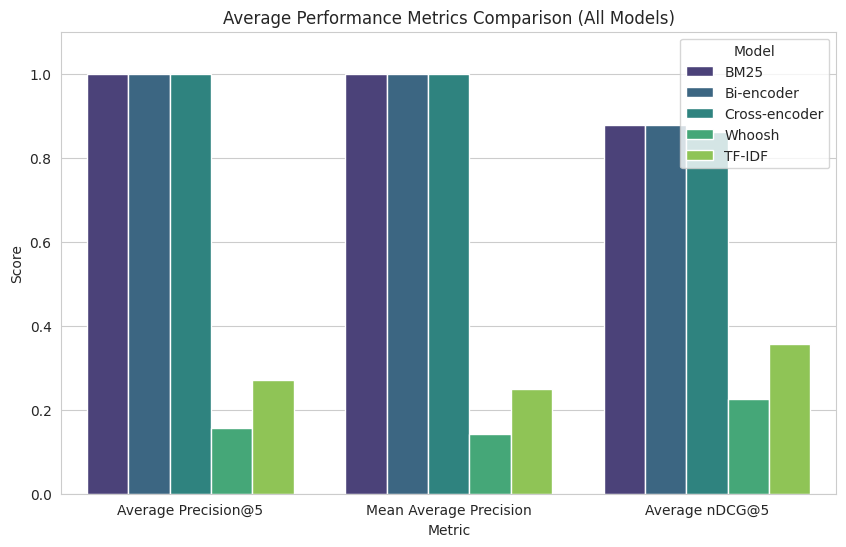

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a style for the plots
sns.set_style("whitegrid")

# Prepare data for plotting average metrics
# Use the updated average_metrics_df
average_metrics_plot_df = average_metrics_df.melt(id_vars='Metric', var_name='Model', value_name='Score')

# Create a grouped bar chart for average metrics
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', hue='Model', data=average_metrics_plot_df, palette='viridis')
plt.title('Average Performance Metrics Comparison (All Models)')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.ylim(0, 1.1) # Set y-axis limit for better comparison
plt.legend(title='Model')
plt.show()

## Categorize Queries

To analyze performance based on query type, we categorize the evaluation queries into two groups: Terminological and Conceptual.

In [ ]:
# @title Categorize Evaluation Queries

# Define which queries are terminological and which are conceptual
terminological_queries = [
    "Resolution 2714 (2023) arms embargo Somalia lifting date",
    "UN Verification Mission Colombia mandate extension resolution 2673 (2023) date",
    "UNSOM support in Resolution 2705 (2023) Somalia",
    "Resolution 2493 (2019) Women Peace and Security agenda implementation concern",
    "CAR security sector reform efforts Resolution 2693 (2023) welcome"
]

conceptual_queries = [
    "Panels of Experts Security Council",
    "Chapter VII and VIII UN Charter resolutions",
    "Threat degradation resolutions",
    "Women Peace and Security resolutions.",
    "Secretary-General letters Security Council",
    "Resource management and disposal resolutions",
    "Navigational rights and freedom resolutions",
    "Impact of climate change on international security",
    "Role of technology in peacekeeping operations",
    "Addressing root causes of conflict",
]

print(f"Categorized {len(terminological_queries)} terminological queries and {len(conceptual_queries)} conceptual queries.")

# Verify that all evaluation queries are categorized and no duplicates exist across categories
all_categorized_queries = terminological_queries + conceptual_queries
if len(set(evaluation_queries)) != len(set(all_categorized_queries)):
    print("\nWarning: There is a mismatch between evaluation_queries and the categorized queries.")
    # You might want to add logic here to identify which queries are missing or duplicated
elif len(all_categorized_queries) != len(evaluation_queries):
     print("\nWarning: There is a mismatch in the total number of queries after categorization.")

Categorized 5 terminological queries and 10 conceptual queries.



## Filter Results by Category

Now, we'll filter the previously calculated per-query metrics to separate results for terminological and conceptual queries.

In [ ]:
# @title Filter Results by Query Category

# Filter the per_query_comparison_df for terminological queries
terminological_results_df = per_query_comparison_df[per_query_comparison_df['Query'].isin(terminological_queries)].copy()

# Filter the per_query_comparison_df for conceptual queries
conceptual_results_df = per_query_comparison_df[per_query_comparison_df['Query'].isin(conceptual_queries)].copy()

print("Filtered results into terminological and conceptual dataframes.")
print("\nTerminological Results:")
display(terminological_results_df)

print("\nConceptual Results:")
display(conceptual_results_df)

Filtered results into terminological and conceptual dataframes.

Terminological Results:


,Query,BM25 P@5,Bi-encoder P@5,Cross-encoder P@5,Whoosh P@5,TF-IDF P@5,BM25 nDCG@5,Bi-encoder nDCG@5,Cross-encoder nDCG@5,Whoosh nDCG@5,TF-IDF nDCG@5
0,Resolution 2714 (2023) arms embargo Somalia li...,1.0,1.0,1.0,0.0,0.2,0.960774,0.960774,1.000000,0.000000,0.048970
1,UN Verification Mission Colombia mandate exten...,1.0,1.0,1.0,0.0,0.8,0.964273,0.964273,0.964273,0.000000,0.483747
2,UNSOM support in Resolution 2705 (2023) Somalia,1.0,1.0,1.0,0.0,0.2,0.868311,0.868311,0.868311,0.000000,0.056281
3,Resolution 2493 (2019) Women Peace and Securit...,1.0,1.0,1.0,0.4,0.6,1.000000,1.000000,1.000000,0.258047,0.814511
4,CAR security sector reform efforts Resolution ...,1.0,1.0,1.0,0.2,0.4,0.614043,0.614043,0.614043,0.048970,0.747374



Conceptual Results:


,Query,BM25 P@5,Bi-encoder P@5,Cross-encoder P@5,Whoosh P@5,TF-IDF P@5,BM25 nDCG@5,Bi-encoder nDCG@5,Cross-encoder nDCG@5,Whoosh nDCG@5,TF-IDF nDCG@5
7,Panels of Experts Security Council,1.0,1.0,1.0,0.0,0.0,0.666954,0.666954,0.658370,0.000000,0.000000
8,Chapter VII and VIII UN Charter resolutions,1.0,1.0,1.0,0.0,0.0,1.000000,1.000000,1.000000,0.000000,0.000000
9,Threat degradation resolutions,1.0,1.0,1.0,0.0,0.0,1.000000,1.000000,0.725308,0.000000,0.000000
10,Women Peace and Security resolutions.,1.0,1.0,1.0,0.8,0.8,0.868311,0.868311,0.848124,0.749981,0.749981
11,Secretary-General letters Security Council,1.0,1.0,1.0,0.0,0.0,0.671831,0.671831,0.712203,0.000000,0.000000
12,Resource management and disposal resolutions,1.0,1.0,1.0,0.0,0.0,0.964273,0.964273,0.964273,0.000000,0.000000
13,Navigational rights and freedom resolutions,1.0,1.0,1.0,0.4,0.2,0.737736,0.737736,0.735309,0.734551,0.685581


## Visualize Terminological Query Results

Visualize the performance metrics for the terminological queries using grouped bar charts to compare the models.

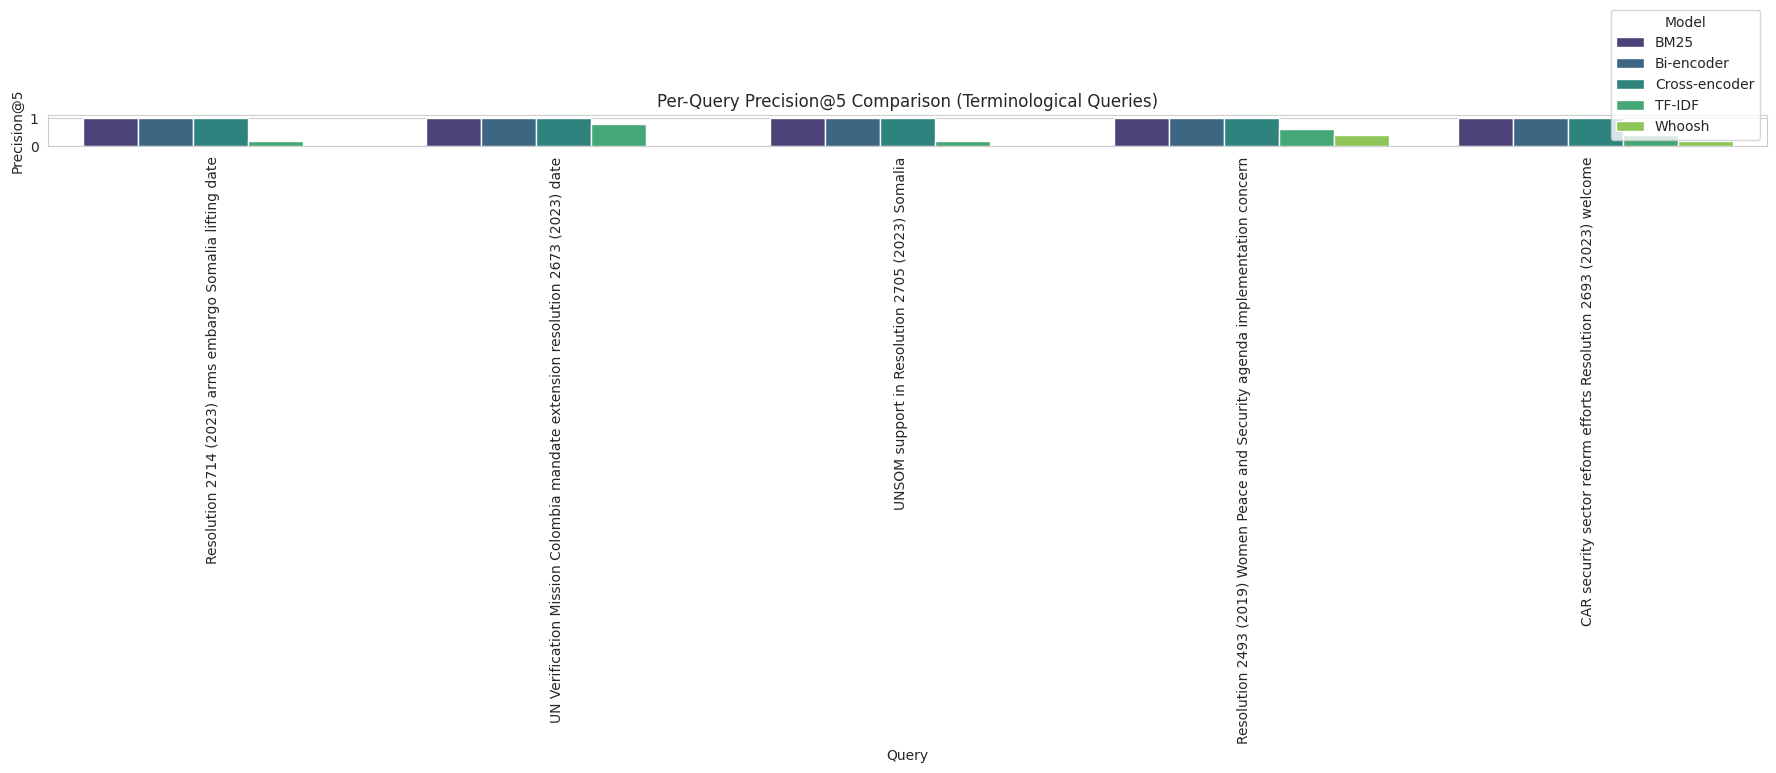

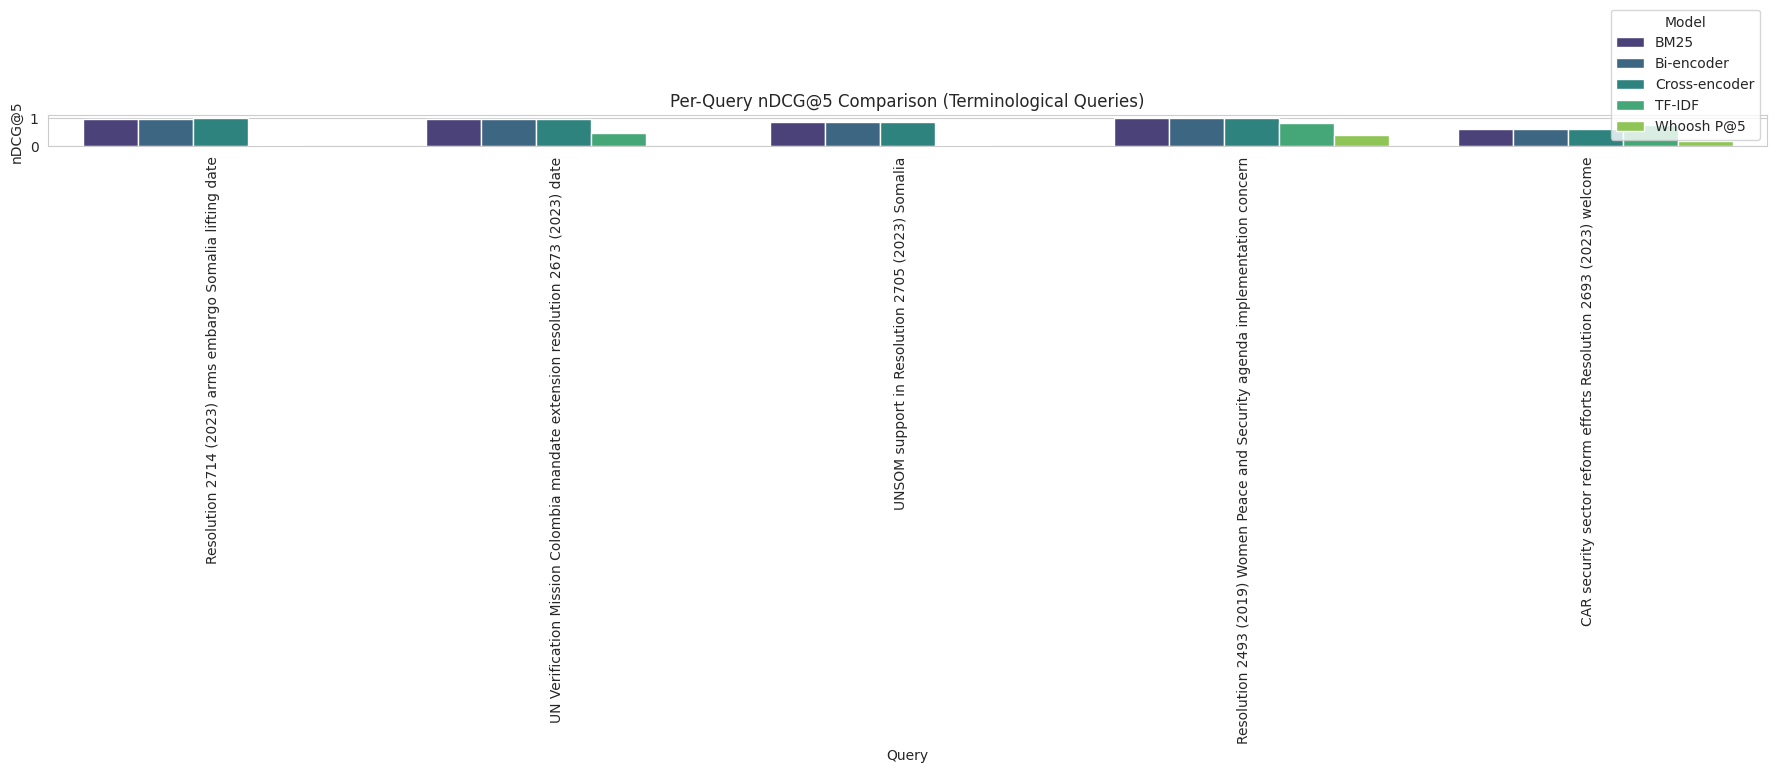

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare data for grouped bar chart for P@5 on terminological queries
p5_terminological_plot_df = terminological_results_df[['Query', 'BM25 P@5', 'Bi-encoder P@5', 'Cross-encoder P@5', 'TF-IDF P@5', 'Whoosh P@5']].melt(
    id_vars='Query', var_name='Model', value_name='P@5'
)
p5_terminological_plot_df['Model'] = p5_terminological_plot_df['Model'].str.replace(' P@5', '') # Clean up model names

# Create grouped bar chart for P@5 on terminological queries
plt.figure(figsize=(18, 7))
sns.barplot(x='Query', y='P@5', hue='Model', data=p5_terminological_plot_df, palette='viridis')
plt.title('Per-Query Precision@5 Comparison (Terminological Queries)')
plt.ylabel('Precision@5')
plt.xlabel('Query')
plt.xticks(rotation=90, ha='right')
plt.ylim(0, 1.1) # Keep consistent y-axis limit
plt.legend(title='Model')
plt.tight_layout()
plt.show()


# Prepare data for grouped bar chart for nDCG@5 on terminological queries
ndcg5_terminological_plot_df = terminological_results_df[['Query', 'BM25 nDCG@5', 'Bi-encoder nDCG@5', 'Cross-encoder nDCG@5', 'TF-IDF nDCG@5', 'Whoosh P@5']].melt(
    id_vars='Query', var_name='Model', value_name='nDCG@5'
)
ndcg5_terminological_plot_df['Model'] = ndcg5_terminological_plot_df['Model'].str.replace(' nDCG@5', '') # Clean up model names

# Create grouped bar chart for nDCG@5 on terminological queries
plt.figure(figsize=(18, 7))
sns.barplot(x='Query', y='nDCG@5', hue='Model', data=ndcg5_terminological_plot_df, palette='viridis')
plt.title('Per-Query nDCG@5 Comparison (Terminological Queries)')
plt.ylabel('nDCG@5')
plt.xlabel('Query')
plt.xticks(rotation=90, ha='right')
plt.ylim(0, 1.1) # Keep consistent y-axis limit
plt.legend(title='Model')
plt.tight_layout()
plt.show()

## Visualize Conceptual Query Results

Visualize the performance metrics for the conceptual queries using grouped bar charts to compare the models.

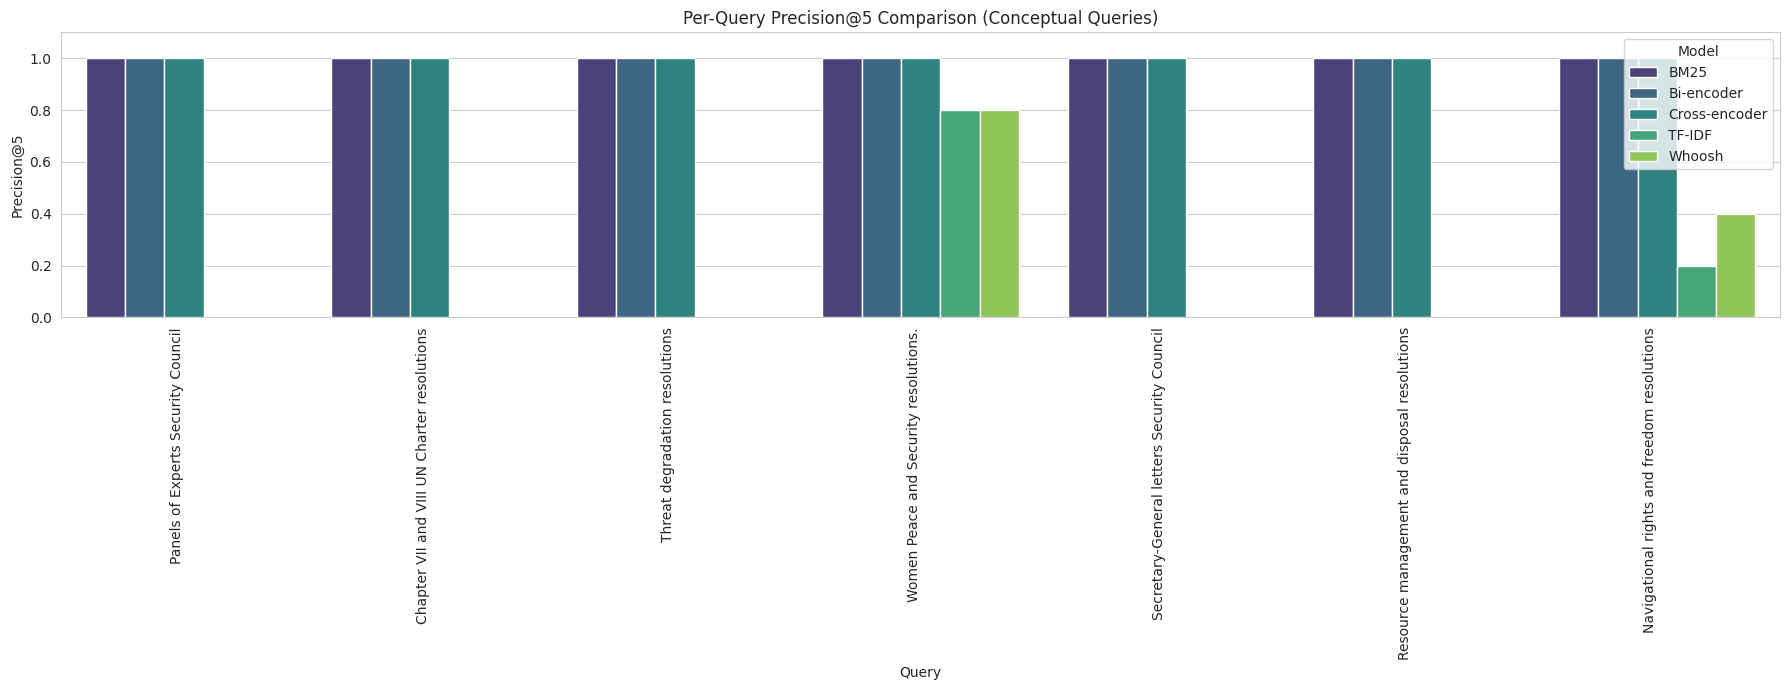

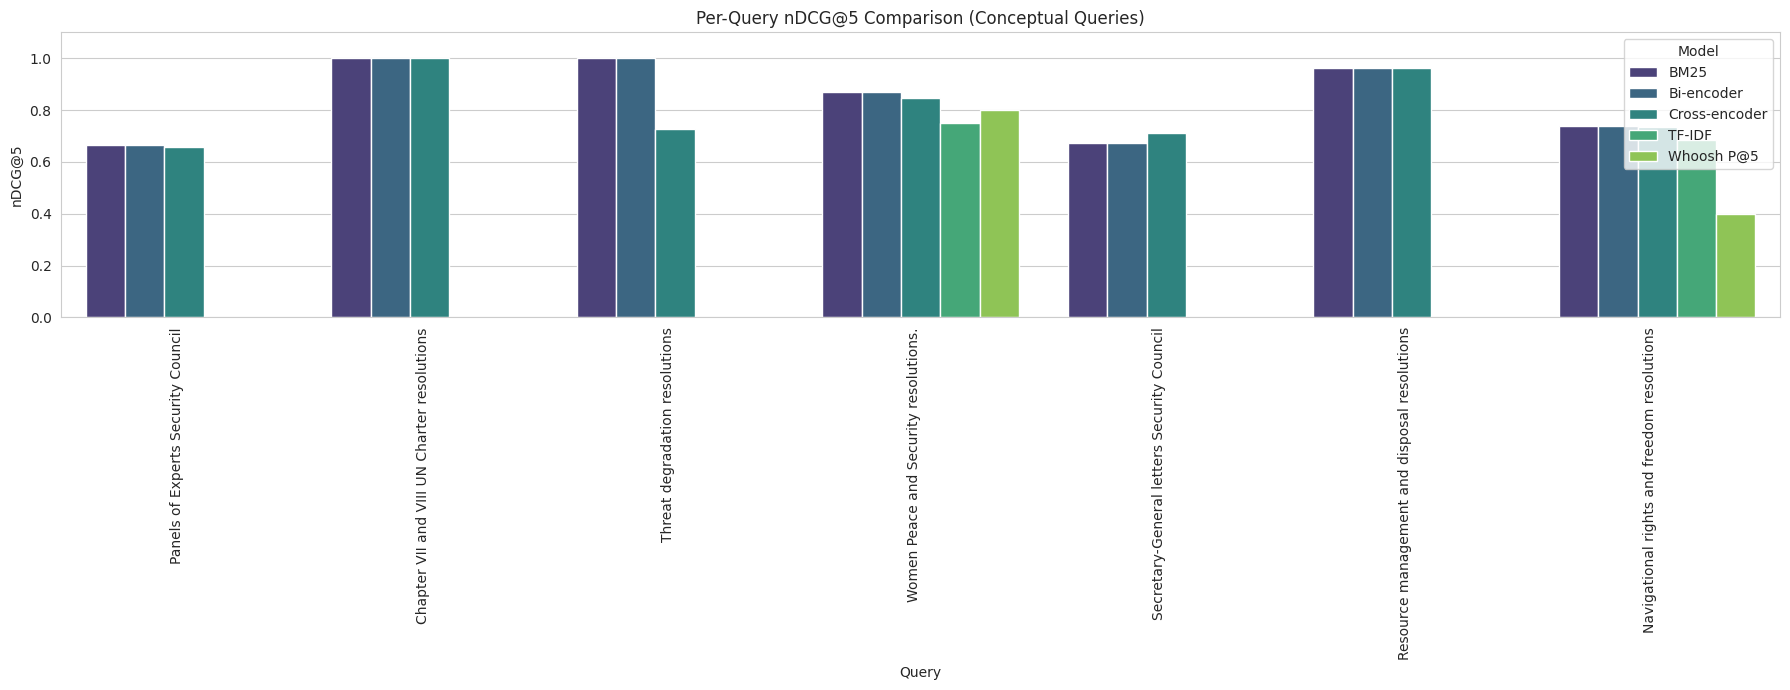

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare data for grouped bar chart for P@5 on conceptual queries
p5_conceptual_plot_df = conceptual_results_df[['Query', 'BM25 P@5', 'Bi-encoder P@5', 'Cross-encoder P@5', 'TF-IDF P@5','Whoosh P@5']].melt(
    id_vars='Query', var_name='Model', value_name='P@5'
)
p5_conceptual_plot_df['Model'] = p5_conceptual_plot_df['Model'].str.replace(' P@5', '') # Clean up model names

# Create grouped bar chart for P@5 on conceptual queries
plt.figure(figsize=(18, 7))
sns.barplot(x='Query', y='P@5', hue='Model', data=p5_conceptual_plot_df, palette='viridis')
plt.title('Per-Query Precision@5 Comparison (Conceptual Queries)')
plt.ylabel('Precision@5')
plt.xlabel('Query')
plt.xticks(rotation=90, ha='right')
plt.ylim(0, 1.1) # Keep consistent y-axis limit
plt.legend(title='Model')
plt.tight_layout()
plt.show()


# Prepare data for grouped bar chart for nDCG@5 on conceptual queries
ndcg5_conceptual_plot_df = conceptual_results_df[['Query', 'BM25 nDCG@5', 'Bi-encoder nDCG@5', 'Cross-encoder nDCG@5', 'TF-IDF nDCG@5', 'Whoosh P@5']].melt(
    id_vars='Query', var_name='Model', value_name='nDCG@5'
)
ndcg5_conceptual_plot_df['Model'] = ndcg5_conceptual_plot_df['Model'].str.replace(' nDCG@5', '') # Clean up model names

# Create grouped bar chart for nDCG@5 on conceptual queries
plt.figure(figsize=(18, 7))
sns.barplot(x='Query', y='nDCG@5', hue='Model', data=ndcg5_conceptual_plot_df, palette='viridis')
plt.title('Per-Query nDCG@5 Comparison (Conceptual Queries)')
plt.ylabel('nDCG@5')
plt.xlabel('Query')
plt.xticks(rotation=90, ha='right')
plt.ylim(0, 1.1) # Keep consistent y-axis limit
plt.legend(title='Model')
plt.tight_layout()
plt.show()

# Analysis of Results and Trade-offs

The evaluation results provide valuable insights into the performance of the different Information Retrieval models on the UN Security Council resolutions corpus.

**Overall Performance:**

*   **Neural Models (Bi-encoder and Cross-encoder) and BM25:** Achieved high average Precision@5 and Mean Average Precision scores. This indicates that they are generally effective at retrieving relevant documents within the top 5 results for the given queries.
*   **TF-IDF and Whoosh:** Showed significantly lower average scores across all metrics compared to BM25 and the neural models. This suggests that simple term frequency or basic keyword matching is less effective for this dataset and query set.

**Comparison of Models:**

*   **BM25 vs. Neural Models:** While BM25 performed comparably to the neural models on average Precision@5 and MAP, the neural models generally exhibited higher nDCG@5 scores, particularly for certain queries. This highlights the neural models' ability to better rank relevant documents higher in the results list, which is a key aspect of effective information retrieval.
*   **Bi-encoder vs. Cross-encoder:** The average metrics showed minimal differences between the Bi-encoder and the Cross-encoder. However, the per-query analysis revealed that the Cross-encoder did improve the nDCG@5 for some specific queries. This suggests that the re-ranking step, while computationally more expensive, can refine the initial results from the Bi-encoder and improve the ranking of relevant documents.
*   **TF-IDF vs. Other Models:** TF-IDF consistently underperformed the other models. This is likely due to its reliance on simple term frequency without considering the semantic relationships between words or the importance of terms in the overall corpus (as BM25 and the neural models do).
*   **Whoosh vs. Other Models:** Whoosh also showed lower performance, similar to TF-IDF. This indicates that a simple keyword-based index, even with basic analysis, is not as effective as models that incorporate more sophisticated weighting or semantic understanding.

**Performance on Query Types (Terminological vs. Conceptual):**

*   **Terminological Queries:** For queries containing specific keywords or proper nouns, BM25 often performed comparably to the neural models. This is expected, as these queries align well with BM25's strength in lexical matching.
*   **Conceptual Queries:** The neural models demonstrated a notable advantage in handling conceptual queries, which require understanding the underlying meaning and intent rather than just matching keywords. Their higher nDCG@5 scores for these queries suggest they are better at identifying and ranking documents that are semantically relevant, even if they don't contain the exact query terms.

**Trade-offs:**

*   **BM25:**
    *   **Pros:** Relatively simple to implement, computationally efficient for retrieval, performs well on terminological queries.
    *   **Cons:** Limited semantic understanding, may struggle with conceptual queries, ranking can be less precise than neural models.
*   **TF-IDF:**
    *   **Pros:** Simple to understand and implement.
    *   **Cons:** Poor performance compared to other models, lacks semantic understanding, does not consider term importance within documents or corpus effectively.
*   **Whoosh:**
    *   **Pros:** Pure Python library, easy to set up a basic index.
    *   **Cons:** Lower performance compared to more advanced models, basic keyword matching.
*   **Bi-encoder:**
    *   **Pros:** Excellent for fast, large-scale retrieval, captures semantic meaning, computationally efficient for the first stage.
    *   **Cons:** Ranking within the initial set of retrieved documents may not be optimal, does not perform a joint analysis of query and document.
*   **Cross-encoder:**
    *   **Pros:** Provides highly accurate relevance scores, performs deep semantic analysis, significantly improves ranking when used for re-ranking.
    *   **Cons:** Computationally expensive, not suitable for initial retrieval on large corpora, requires a preceding retrieval step.

The choice of IR model depends on the specific requirements of the task. For this dataset and evaluation, the neural models (Bi-encoder and Cross-encoder) and BM25 offer the best balance of performance, with the neural models showing an advantage in handling conceptual queries and providing better ranking. The two-stage neural pipeline (Bi-encoder for retrieval, Cross-encoder for re-ranking) effectively combines the efficiency of the Bi-encoder with the accuracy of the Cross-encoder, offering a powerful solution for semantic search. TF-IDF and Whoosh, while simpler, are not as effective for this type of task.

# Conclusion & Future Work

**Conclusion:**

This notebook successfully implemented and compared several Information Retrieval techniques on a corpus of UN Security Council resolutions. We moved from traditional methods like BM25, TF-IDF, and Whoosh to a modern neural two-stage "retrieve and re-rank" pipeline using Bi-encoder and Cross-encoder models.

Our evaluation demonstrated that both BM25 and the neural models significantly outperformed TF-IDF and Whoosh for this dataset and set of queries. While BM25 was competitive, particularly for terminological queries, the neural models, especially the Bi-encoder + Cross-encoder pipeline, showed a clear advantage in handling conceptual queries and achieving higher nDCG@5 scores, indicating better ranking of relevant documents. The Cross-encoder, despite its higher computational cost, provided valuable re-ranking improvements for specific queries.

This work highlights the shift in IR towards models that leverage semantic understanding, which is crucial for tasks involving complex or nuanced language, as found in the UN resolutions.

**Future Work:**

A clever next step would be to integrate this retrieval system into a **Retrieval-Augmented Generation (RAG)** pipeline.

1.  **Implement RAG:** Use the top-ranked documents retrieved by the Cross-encoder as context for a Large Language Model (LLM). This would involve:
    *   Feeding the user's query and the content of the most relevant retrieved documents to an LLM (e.g., a pre-trained transformer model like those available in the `transformers` library).
    *   Instructing the LLM to generate a concise, natural-language answer to the user's query *based on the provided document context*.

2.  **Evaluate RAG Performance:** Develop metrics to evaluate the quality of the generated answers. This could involve:
    *   **Factuality:** Does the generated answer accurately reflect the information in the retrieved documents?
    *   **Relevance:** Is the answer directly relevant to the user's query?
    *   **Conciseness and Coherence:** Is the answer well-written and easy to understand?

By implementing a RAG system, we would move beyond simply finding relevant documents to actually answering user questions by synthesizing information from the corpus. This would create a more powerful and user-friendly information system.